# Cough Droplets Partitioning

Welcome to the **Cough Droplets Partitioning** notebook—a step-by-step walkthrough to help you set up and run **multi-component aerosol simulations** using the [**Particula**](https://github.com/uncscode/particula) Python package.

This example focuses on modeling **cough droplets**, a mixture of water, salts, and biological materials, as they **evaporate** under different humidity conditions.

### 🌟 What This Notebook Covers

In this notebook, you’ll learn how to:

1. **Model realistic aerosol particles** (like cough droplets)
2. **Set up species properties** (molar masses, densities, hygroscopicity)
3. **Construct gas-phase and particle-phase objects**
4. **Run isothermal evaporation simulations**
5. **Visualize how particle size and composition change over time**

### 💡 Why It Matters

Cough droplets are central to human exposure studies:

* They can carry infectious agents
* Influence **indoor air quality**
* Affect **aerosol dynamics** in confined environments like classrooms, hospitals, or aircraft cabins

### 🚀 Getting Started

This notebook is beginner-friendly. No prior experience with **Particula** or aerosol modeling is needed. Each step is clearly explained and includes code snippets to help you build intuition and experiment with your own setups.


In [1]:
# 🚧 Install Particula if you're running this in Google Colab
# Remove the comment below to enable installation
# !pip install particula[extra] --quiet

# 📦 Import necessary libraries
import copy  # to safely duplicate Python objects

import matplotlib.pyplot as plt  # for plotting
import numpy as np  # numerical tools
import particula as par  # the main Particula package
from tqdm import tqdm  # optional: for progress bars during simulation

# 🎨 Set default plot styling using Tailwind-inspired colors from Particula
TAILWIND = par.util.colors.TAILWIND
base_color = TAILWIND["gray"]["600"]

plt.rcParams.update(
    {
        "text.color": base_color,
        "axes.labelcolor": base_color,
        "figure.figsize": (5, 4),
        "font.size": 14,
        "axes.edgecolor": base_color,
        "xtick.color": base_color,
        "ytick.color": base_color,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    }
)

## 🧪 Defining Chemical Species in Cough Droplets

In this section, we define the **chemical makeup** of the simulated cough droplets. These are **multi-component aerosols** made up of water, salts, buffers, proteins, and other organics commonly found in human respiratory fluids.

### 🔬 Chemical Components

We create a list of **12 representative chemicals** that capture the diversity of real cough droplet composition:

* **Water** (main solvent)
* **Inorganic salts** like NaCl, KHCO₃, KH₂PO₄, Ca(HCO₃)₂, Mg(HCO₃)₂
* **Organic compounds** like urea, glucose, and lactate
* **Biological macromolecules** like **lysozyme**, **IgA**, and **cholesterol**

### 📊 Initial Mass Fractions

For each chemical, we define a **range of initial mass fractions** that represent its likely concentration in fresh respiratory droplets. These values are approximate and intended to capture real-world variability.

### ⚙️ Automatic Property Retrieval

Using Particula’s `get_chemical_search()` and `get_chemical_stp_properties()` utilities, we fetch:

* **Molar mass** *(kg/mol)*
* **Density** *(kg/m³)*
* **Surface tension** *(N/m)*
* **Vapor pressure** *(Pa)*
* **Molecular identity** (e.g. SMILES, CAS)

These properties are needed to accurately simulate **evaporation, condensation, and phase partitioning**.

### 🛠 Manual Adjustment

We manually correct the surface tension for **NaCl**, since tabulated value was for the solid phase. Here, we use a typical value of `0.091 N/m`.

### 🧾 Output

For each species, the notebook prints:

* Name, CAS identifier, SMILES string
* Molar mass, density, surface tension, and vapor pressure

This lets you verify the chemical setup before moving forward with building the aerosol system.

In [2]:
list_of_chemicals = [
    "Water",
    "NaCl",
    "potassium bicarbonate (KHCO3)",
    "potassium dihydrogen phosphate (KH2PO4)",  # K+ + H2PO4–
    "calcium bicarbonate [Ca(HCO3)2]",
    "magnesium bicarbonate [Mg(HCO3)2]",
    "Urea",
    "Lactate",
    "Glucose",
    "Lysozyme",
    "IgA",
    "cholesterol",
]
initial_mass_fraction_bounds = [
    (0.985, 0.995),  # Water
    (0.0006, 0.0023),  # NaCl
    (0.0007, 0.0030),  # KHCO3
    (0.0002, 0.0027),  # KH2PO4
    (0.00002, 0.00045),  # Ca(HCO3)2
    (0.000006, 0.00003),  # Mg(HCO3)2
    (0.0002, 0.0015),  # Urea
    (0.00005, 0.0004),  # Lactate
    (0.00001, 0.0002),  # Glucose
    (0.000005, 0.00002),  # Lysozyme
    (0.00002, 0.0002),  # IgA
    (0.00005, 0.0005),  # Cholesterol
]

density_array = np.array([])
molar_mass_array = np.array([])
surface_tension_array = np.array([])
short_name = []
chemical_dict = {}
# Get the CAS numbers for each chemical
for chem in list_of_chemicals:
    cas = par.util.get_chemical_search(chem)
    print(f"{chem}: {cas}")
    chemical_dict[chem] = par.util.get_chemical_stp_properties(cas)
    # Store the molar mass and density
    molar_mass_array = np.append(
        molar_mass_array, chemical_dict[chem]["molar_mass"]
    )
    density_array = np.append(density_array, chemical_dict[chem]["density"])
    surface_tension_array = np.append(
        surface_tension_array, chemical_dict[chem]["surface_tension"]
    )
    short_name.append(chemical_dict[chem]["name"])

# correct NaCl surface tension
surface_tension_array[1] = 0.091  # N/m, typical value

# Print the chemical properties
for chem, props in chemical_dict.items():
    print(f"{chem}:")
    print(f"  Name: {props['name']}")
    print(f"  CAS: {props['cas_number']}")
    print(f"  Smiles: {props['smiles']}")
    print(f"  Molar Mass: {props['molar_mass']:.4f} kg/mol")
    print(f"  Density: {props['density']:.2f} kg/m³")
    print(f"  Surface Tension: {props['surface_tension']} N/m")
    print(f"  Vapor Pressure: {props['pure_vapor_pressure']} Pa\n")

Water: Water
NaCl: NaCl
potassium bicarbonate (KHCO3): potassium bicarbonate (KHCO3)
potassium dihydrogen phosphate (KH2PO4): potassium dihydrogen phosphate (KH2PO4)
calcium bicarbonate [Ca(HCO3)2]: calcium carbonate [usan]
magnesium bicarbonate [Mg(HCO3)2]: magnesium carbonate (mgco3)
Urea: Urea
Lactate: Lactate
Glucose: Glucose
Lysozyme: soy-dome
IgA: IgA
cholesterol: cholesterol
Water:
  Name: water
  CAS: 7732-18-5
  Smiles: O
  Molar Mass: 0.0180 kg/mol
  Density: 997.06 kg/m³
  Surface Tension: 0.07197220523022962 N/m
  Vapor Pressure: 3169.9293388738784 Pa

NaCl:
  Name: sodium chloride
  CAS: 7647-14-5
  Smiles: [Na+].[Cl-]
  Molar Mass: 0.0584 kg/mol
  Density: 2169.99 kg/m³
  Surface Tension: 0.35290821232462 N/m
  Vapor Pressure: 2.245741871175006e-30 Pa

potassium bicarbonate (KHCO3):
  Name: potassium bicarbonate
  CAS: 298-14-6
  Smiles: C(=O)(O)[O-].[K+]
  Molar Mass: 0.1001 kg/mol
  Density: 2170.00 kg/m³
  Surface Tension: None N/m
  Vapor Pressure: None Pa

potassium 

## 🧮 Step 1: Set Up Particle and Species Properties

### 🎲 Reproducibility

To ensure that simulations can be reproduced exactly (e.g. for comparison or debugging), we seed NumPy’s random number generator:

```python
np.random.seed(100)
```

---

### 🧫 1a. Define Particle Sampling and Environmental Conditions

We now define the **simulation scale** and **temperature conditions**:

* `number_of_samples`: number of particles we’ll track individually
* `total_number_per_cm3`: assumed number concentration in the air
* `simulation_volume`: computed simulation volume based on the above
* `temperature`: constant system temperature (isothermal)

This configuration controls the **scale and realism** of the simulation.

---

### 🌡 1b. Assign Vapor Pressure Strategies

Each species needs a **vapor pressure strategy**, which defines how readily it transitions between the gas and particle phases.

We retrieve each species’ vapor pressure (at room temperature), and if missing, assign a **small fallback value**. Then we use Particula’s `ConstantVaporPressureBuilder` to build the vapor behavior for each compound.

> ⚠️ Surface tensions are also cleaned: if missing, a default of `0.072 N/m` is applied (typical for water at 25°C).


In [3]:

# 🎲 Ensure reproducibility
np.random.seed(100)

# 🔢 Simulation settings
number_of_samples = 1_000  # Number of particles to simulate
total_number_per_cm3 = 1e-4  # Particle number concentration [#/cm³]
simulation_volume = (
    number_of_samples / total_number_per_cm3 * 1e-6
)  # Simulation volume in m³ (converted from cm³)

temperature = 298.15  # System temperature in Kelvin (25°C)

# 🌡 Build vapor pressure strategies for each chemical
vapor_pressure_strategy_list = []

for chem_i, props in chemical_dict.items():
    vapor_pressure_temp = props["pure_vapor_pressure"]

    if vapor_pressure_temp is None:
        print(f"⚠️ Warning: No vapor pressure data for {chem_i}, using default.")
        vapor_pressure_temp = 1e-30  # fallback for non-volatile species

    vapor_pressure_i = (
        par.gas.ConstantVaporPressureBuilder()
        .set_vapor_pressure(vapor_pressure_temp, "Pa")
        .build()
    )

    vapor_pressure_strategy_list.append(vapor_pressure_i)

# 💧 Ensure surface tension values are set
surface_tension_array = np.array(
    [0.072 if x is None else x for x in surface_tension_array]
)

⚠️ Warning: No vapor pressure data for potassium bicarbonate (KHCO3), using default.
⚠️ Warning: No vapor pressure data for potassium dihydrogen phosphate (KH2PO4), using default.
⚠️ Warning: No vapor pressure data for calcium bicarbonate [Ca(HCO3)2], using default.
⚠️ Warning: No vapor pressure data for magnesium bicarbonate [Mg(HCO3)2], using default.


## 🌬 Step 2: Set Up the Gas-Phase Environment

To simulate how particles exchange mass with the air (e.g. water evaporating), we need to define the surrounding **gas-phase composition** and **thermodynamic conditions**.

### 💧 Relative Humidity for Water

We begin by setting **near-zero concentrations** for all species in the gas phase to simulate dry air. Then we adjust the water vapor concentration to simulate a **30% relative humidity** environment:

* The saturation concentration for water is calculated using its vapor pressure strategy.
* The RH is applied by multiplying by 0.3.

### 🧪 Building Gas-Phase Species

We use `GasSpeciesBuilder()` to define:

* Species names and molar masses
* Their ability to partition
* Vapor pressure strategies
* Initial gas-phase concentrations

### 🌡 Creating the Atmosphere

Finally, we construct the atmosphere with temperature, pressure, and link the gas-phase species. This environment will be used to govern **evaporation/condensation dynamics** during the simulation.


In [4]:

# 💨 Initialize gas-phase concentrations near zero
concentration_gas = np.ones(len(list_of_chemicals)) * 1e-30  # kg/m³

# 💧 Set water vapor to 30% RH
isat_water = vapor_pressure_strategy_list[0].saturation_concentration(
    molar_mass_array[0], temperature
)
concentration_gas[0] = isat_water * 0.3  # 30% RH

# 🧪 Build gas-phase species with vapor strategies and concentrations
gas_species = (
    par.gas.GasSpeciesBuilder()
    .set_name(np.array(list_of_chemicals))
    .set_molar_mass(molar_mass_array, "kg/mol")
    .set_partitioning(True)
    .set_vapor_pressure_strategy(vapor_pressure_strategy_list)
    .set_concentration(concentration_gas, "kg/m^3")
    .build()
)

# 🌡 Create atmosphere: includes temperature, pressure, and gas species
atmosphere = (
    par.gas.AtmosphereBuilder()
    .set_more_partitioning_species(gas_species)
    .set_temperature(temperature, "K")
    .set_pressure(1, "atm")
    .build()
)

## 💠 Step 3: Define Particle Composition and Build the Aerosol Phase

Now that the gas-phase environment is ready, we define the **particle-phase system**—realistic cough droplets containing a mix of water, salts, organics, and proteins.

### 🌡 3a. Size Distribution of Cough Droplets

Human coughs produce droplets from different regions of the respiratory tract, which can be modeled using **lognormal size distributions**:

* **Bronchiolar:** smaller mode (\~0.3 μm radius)
* **Laryngeal:** medium mode (\~4 μm radius)
* **Oropharyngeal:** large mode (\~40 μm radius)

We use `par.particles.get_lognormal_sample_distribution()` to sample droplet **radii** based on these modes, weighted by their relative occurrence.

### 💧 3b. Assign Mass Composition

We assume all particles start as **water droplets**, then apply **random mass fractions** to simulate different droplet compositions. These fractions are sampled from the ranges defined earlier for each chemical species.

### ⚗️ 3c. Define Activity and Surface Strategies

We use **κ-Köhler theory** to estimate hygroscopicity, setting `kappa` values for each species. This is fed into `ActivityKappaParameterBuilder`.

We also define a **surface tension strategy** that accounts for the mass of each component using `SurfaceStrategyMassBuilder`.

---

### 🧱 Create the Resolved Particle and Aerosol System

We wrap everything into a `ResolvedParticleMassRepresentation` and then build the full **Aerosol** object by combining:

* Particle-phase definition (`resolved_masses`)
* Gas-phase environment (`atmosphere`)

This sets up the full simulation-ready aerosol system.

In [5]:

# 💠 3a. Lognormal size distributions for cough droplet modes
# Modes: bronchiolar, laryngeal, oropharyngeal
modes = np.array([0.6, 8.0, 80.0]) / 2 * 1e-6  # radii in meters
geometric_standard_deviations = np.array([1.65, 2.4, 1.6])
relative_number = np.array([15, 2, 0.2])  # relative weights

# Generate sampled radii
radii_cough = par.particles.get_lognormal_sample_distribution(
    mode=modes,
    geometric_standard_deviation=geometric_standard_deviations,
    number_of_particles=relative_number,
    number_of_samples=number_of_samples,
)

# 💧 3b. Assign initial water mass and scale by chemical mass fractions
mass_water = 4 / 3 * np.pi * (radii_cough**3) * density_array[0]

mass_speciation = np.repeat(
    mass_water[:, np.newaxis], len(list_of_chemicals), axis=1
)

# Apply random mass fractions from defined bounds
for i, (_chem, bounds) in enumerate(
    zip(list_of_chemicals, initial_mass_fraction_bounds)
):
    mass_fraction = np.random.uniform(bounds[0], bounds[1], number_of_samples)
    mass_speciation[:, i] *= mass_fraction

# ⚗️ 3c. Define activity strategy using kappa parameters
kappa_parameter = np.array(
    [0.0, 1.1, 0.6, 0.6, 0.6, 0.6, 0.3, 0.2, 0.1, 0.1, 0.1, 0.01]
)

activity_strategy = (
    par.particles.ActivityKappaParameterBuilder()
    .set_molar_mass(molar_mass_array, "kg/mol")
    .set_density(density_array, "kg/m^3")
    .set_kappa(kappa_parameter)
    .set_water_index(0)
    .build()
)

# Define surface tension strategy
surface_strategy = (
    par.particles.SurfaceStrategyMassBuilder()
    .set_surface_tension(surface_tension_array, "N/m")
    .set_density(density_array, "kg/m^3")
    .set_phase_index(np.arange(len(list_of_chemicals)))
    .build()
)

# 🧱 3d. Build resolved particle object
resolved_masses = (
    par.particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(par.particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(activity_strategy)
    .set_surface_strategy(surface_strategy)
    .set_mass(mass_speciation, "kg")
    .set_density(density_array, "kg/m^3")
    .set_charge(0)
    .set_volume(simulation_volume, "m^3")
    .build()
)

# Combine gas and particle phases into full aerosol system
aerosol = par.Aerosol(atmosphere=atmosphere, particles=resolved_masses)

# Optional: print summary of aerosol system
print(aerosol)

Gas mixture at 298.15 K, 101325.0 Pa, partitioning=['Water' 'NaCl' 'potassium bicarbonate (KHCO3)'
 'potassium dihydrogen phosphate (KH2PO4)'
 'calcium bicarbonate [Ca(HCO3)2]' 'magnesium bicarbonate [Mg(HCO3)2]'
 'Urea' 'Lactate' 'Glucose' 'Lysozyme' 'IgA' 'cholesterol'], gas_only_species=None
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyMass
	Mass Concentration: 8.933e-10 [kg/m^3]
	Number Concentration: 1.000e+02 [#/m^3]


## 📊 Step 4: Visualize the Initial Particle Size Distribution

Before simulating evaporation or chemical evolution, let’s examine the initial state of the aerosol system we’ve just created.

### 🧾 Summary of the Initialized System

At this point, the system contains:

* **Gas Mixture** at:

  * Temperature: `298.15 K`
  * Pressure: `101325 Pa` (1 atm)
  * Partitioning Species: Water, salts, organics, proteins
* **Particle Representation**:

  * Strategy: `ParticleResolvedSpeciatedMass`
  * Activity Model: `ActivityKappaParameter`
  * Surface Model: `SurfaceStrategyMass`
  * Mass Concentration: \~`1.6 × 10⁻⁹ kg/m³`
  * Number Concentration: `1.0 × 10² #/m³`

### 📈 Plotting Initial Size Distribution

To visualize the initial aerosol size distribution:

* We extract particle **radii** using `aerosol.particles.get_radius()`
* Convert to **log10 scale** (standard for aerosol data)
* Plot a histogram to show how particle sizes are distributed


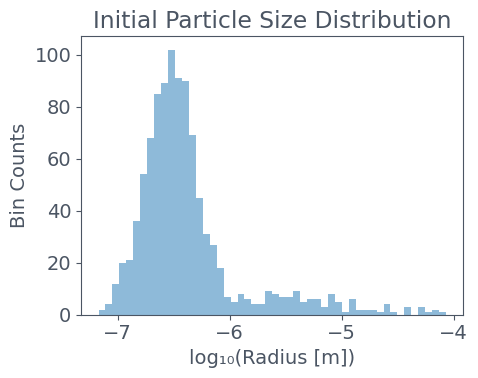

In [6]:

fig, ax = plt.subplots()

# Log-scale histogram of particle radii
ax.hist(
    np.log10(aerosol.particles.get_radius()),  # convert to log10
    bins=50,
    density=False,
    alpha=0.5,
)

ax.set_xlabel("log₁₀(Radius [m])")
ax.set_ylabel("Bin Counts")
ax.set_title("Initial Particle Size Distribution")
plt.tight_layout()
plt.show()

## 🔁 Step 5: Define Aerosol Dynamics – Condensation & Coagulation

To simulate how aerosol particles **evolve in time**, we need to define physical processes that change their size, mass, and composition.

In this example, we model:

### 💧 5a. Isothermal Condensation

We simulate **mass transfer from the gas phase to particles** via isothermal condensation. Particula’s `CondensationIsothermal` model accounts for:

* **Molar mass** of each species
* **Diffusion coefficient** (typically \~2e-5 m²/s for air)
* **Accommodation coefficient** (set to 1 for full sticking)

This sets up a `MassCondensation` process that can be used during time evolution.

### ⚪ 5b. Brownian Coagulation

We also define a **Brownian coagulation process**, where particles randomly collide and merge based on their sizes and thermal motion. This uses Particula’s:

* `BrownianCoagulationBuilder()` with `particle_resolved` distribution
* Wrapped into a `Coagulation` object


In [7]:

# 💧 Isothermal Condensation
condensation_strategy = par.dynamics.CondensationIsothermal(
    molar_mass=np.array(molar_mass_array),
    diffusion_coefficient=2e-5,  # typical air value [m²/s]
    accommodation_coefficient=1,  # full sticking efficiency
    # skip_partitioning_indices=[]      # optional: exclude species
)
condensation_process = par.dynamics.MassCondensation(condensation_strategy)

# ⚪ Brownian Coagulation
coagulation_strategy = (
    par.dynamics.BrownianCoagulationBuilder()
    .set_distribution_type("particle_resolved")  # use individual particles
    .build()
)
coagulation_process = par.dynamics.Coagulation(coagulation_strategy)

## ⏱ Step 6: Run the Simulation Loop

Now that the aerosol system and physical processes are set up, we simulate how particles **change over time** due to **condensation** and optionally **coagulation**.

---

### ⚙️ Simulation Settings

* **Duration:** 120 seconds
* **Steps:** 120
* **Condensation sub-steps:** 10 (to improve resolution for fast vapor interactions)
* **Coagulation sub-steps:** 1 (low priority here due to low concentration)

```python
time_array = np.linspace(0, total_time, total_steps)
time_step = total_time / total_steps
```

---

### 💾 Data Tracking

At each time step, we record:

* Particle **size distribution** (histogram of radii)
* **Species mass** across all particles
* **Gas-phase saturation ratio** for each chemical

The size distribution is stored in log-spaced bins ranging from **10⁻⁸ to 10⁻⁴ m** — a typical range for atmospheric aerosol particles.

---

### 🧪 Optional: Toggle Physical Processes

Users can choose to:

* **Fix the water vapor concentration** (e.g. simulate a constant RH environment)
* **Disable condensation or coagulation** individually to isolate effects

These are included as commented lines in the code and easy to turn on/off.


In [8]:

print(aerosol)  # print system state before simulation

# 🔁 Deep copy for simulation
aerosol_process = copy.deepcopy(aerosol)

# Simulation parameters
total_time = 20  # seconds
total_steps = 200

condensation_sub_step = 10
coagulation_sub_step = 1

time_step = total_time / total_steps
time_array = np.linspace(0, total_time, total_steps)
time_len = len(time_array)

# 📊 Initialize arrays for tracking outputs
bins_lognormal = np.logspace(-8, -4, 100)
distribution_counts = np.zeros((time_len, len(bins_lognormal) - 1))
species_mass = np.zeros((time_len, len(list_of_chemicals)))
vapor_saturation = np.zeros((time_len, len(list_of_chemicals)))

# 🌀 Time integration loop
for step, _t in enumerate(
    tqdm(time_array, desc="Running Sim", mininterval=0.5)
):
    if step > 0:
        # Optional: fix water vapor concentration (e.g. controlled RH)
        # aerosol_process.atmosphere.partitioning_species.concentration[0] = (
        #     aerosol.atmosphere.partitioning_species.concentration[0]
        # )

        # 💧 Execute condensation
        aerosol_process = condensation_process.execute(
            aerosol=aerosol_process,
            time_step=time_step,
            sub_steps=condensation_sub_step,
        )

        # ⚪ Optional: execute coagulation
        # aerosol_process = coagulation_process.execute(
        #     aerosol=aerosol_process,
        #     time_step=time_step,
        #     sub_steps=coagulation_sub_step,
        # )

    # Record size distribution
    distribution_counts[step, :], edges = np.histogram(
        aerosol_process.particles.get_radius(clone=True),
        bins=bins_lognormal,
        density=False,
    )

    # Record species mass in particles
    species_temp = aerosol_process.particles.get_species_mass(clone=True)
    species_mass[step, :] = np.sum(species_temp, axis=0)

    # Record vapor saturation ratios
    vapor_saturation[step, :] = (
        aerosol_process.atmosphere.partitioning_species.get_saturation_ratio(
            temperature=temperature
        )
    )

# Normalize counts to number concentration (#/m³)
concentrations = distribution_counts / simulation_volume

# Final system state
print(aerosol_process)

Gas mixture at 298.15 K, 101325.0 Pa, partitioning=['Water' 'NaCl' 'potassium bicarbonate (KHCO3)'
 'potassium dihydrogen phosphate (KH2PO4)'
 'calcium bicarbonate [Ca(HCO3)2]' 'magnesium bicarbonate [Mg(HCO3)2]'
 'Urea' 'Lactate' 'Glucose' 'Lysozyme' 'IgA' 'cholesterol'], gas_only_species=None
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyMass
	Mass Concentration: 8.933e-10 [kg/m^3]
	Number Concentration: 1.000e+02 [#/m^3]


Running Sim: 100%|██████████| 200/200 [00:02<00:00, 96.21it/s]

Gas mixture at 298.15 K, 101325.0 Pa, partitioning=['Water' 'NaCl' 'potassium bicarbonate (KHCO3)'
 'potassium dihydrogen phosphate (KH2PO4)'
 'calcium bicarbonate [Ca(HCO3)2]' 'magnesium bicarbonate [Mg(HCO3)2]'
 'Urea' 'Lactate' 'Glucose' 'Lysozyme' 'IgA' 'cholesterol'], gas_only_species=None
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityKappaParameter
	Surface: SurfaceStrategyMass
	Mass Concentration: 5.603e-12 [kg/m^3]
	Number Concentration: 1.000e+02 [#/m^3]


## 📉 Step 7: Compare Initial and Final Size Distributions

This plot shows how the **particle size distribution** evolved during the simulation.

### 📌 What It Shows:

* **Dashed line**: Initial size distribution before simulation
* **Solid line**: Final distribution after 120 seconds
* **X-axis (log scale)**: Particle radius in meters
* **Y-axis**: Particle number concentration (#/m³)

### 🧪 What to Look For:

* If the **final peak shifts left**, particles are **shrinking** due to **evaporation**
* If the peak moves right or broadens, it may indicate **condensation or growth**
* In this case, we observe a **leftward shift** for larger particles, consistent with **net evaporation**


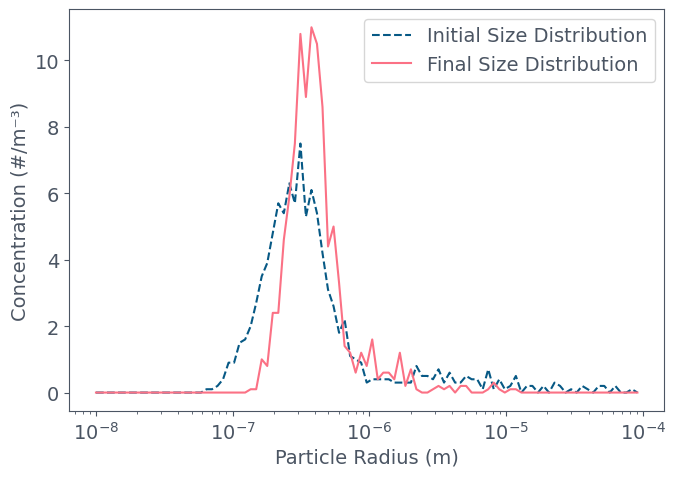

In [9]:

fig, ax = plt.subplots(figsize=(7, 5))

# Get radii before and after simulation
initial_distribution = aerosol.particles.get_radius(clone=True)
final_distribution = aerosol_process.particles.get_radius(clone=True)

# Compute binned counts
counts_initial, _ = np.histogram(
    initial_distribution, bins=bins_lognormal, density=False
)
counts_final, _ = np.histogram(
    final_distribution, bins=bins_lognormal, density=False
)

# Plot initial distribution
ax.plot(
    bins_lognormal[:-1],
    counts_initial / simulation_volume,
    label="Initial Size Distribution",
    color=TAILWIND["sky"]["800"],
    linestyle="--",
)

# Plot final distribution
ax.plot(
    bins_lognormal[:-1],
    counts_final / simulation_volume,
    label="Final Size Distribution",
    color=TAILWIND["rose"]["400"],
    linestyle="-",
)

# Set axis scales and labels
ax.set_xscale("log")
ax.set_xlabel("Particle Radius (m)")
ax.set_ylabel("Concentration (#/m⁻³)")
ax.legend()
plt.tight_layout()
plt.show()

## 💧 Step 8: Track Water Vapor Saturation Over Time

To understand how the gas phase responds during the simulation, we track the **vapor saturation ratio for water** (RH) throughout the 120 seconds.

### 🔍 What Is the Saturation Ratio?

The **saturation ratio** is the ratio of actual vapor concentration to the saturation vapor concentration at a given temperature. For water:

$$
\text{Saturation Ratio} = \frac{C_{\text{vapor}}}{C_{\text{sat}}}
$$

* **1.0** indicates equilibrium (100% RH)
* **< 1.0** indicates subsaturation
* **> 1.0** indicates supersaturation

### 📌 What We Learn:

In this case, the saturation ratio remains **nearly constant**, meaning:

* The **amount of water vapor in the gas phase** is high enough
* The **mass transferred into particles** (via condensation or evaporation) is **too small** to significantly disturb the vapor reservoir

This is typical in **low mass-loading regimes**, such as indoor air with sparse respiratory aerosols.

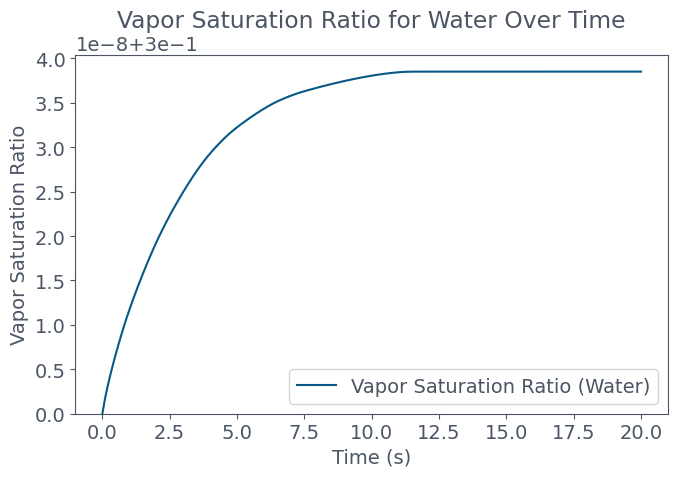

In [10]:

fig, ax = plt.subplots(figsize=(7, 5))

# Plot water vapor saturation ratio (species index 0)
ax.plot(
    time_array,
    vapor_saturation[:, 0],
    color=TAILWIND["sky"]["800"],
    label="Vapor Saturation Ratio (Water)",
)

ax.set_ylim(bottom=0.3)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vapor Saturation Ratio")
ax.set_title("Vapor Saturation Ratio for Water Over Time")
ax.legend()

plt.tight_layout()
plt.show()

## 🧪 Step 9: Track Composition Evolution – Particle Mass Fractions

As water evaporates from particles, their **composition changes** over time. This plot shows the **mean mass fraction** of each species remaining in the particles during the simulation.

### 📌 What This Plot Tells Us:

* **Water** (sky blue) dominates at the start
* As evaporation progresses, **non-volatile species** (salts, organics, proteins) become **relatively more concentrated**
* **Supermicron particles** (initially 4–40 μm) retain water much longer, showing water mass persists before stabilizing.

This plot illustrates **size-dependent evaporation timescales**: larger droplets lose water more slowly due to lower surface-area-to-volume ratios.


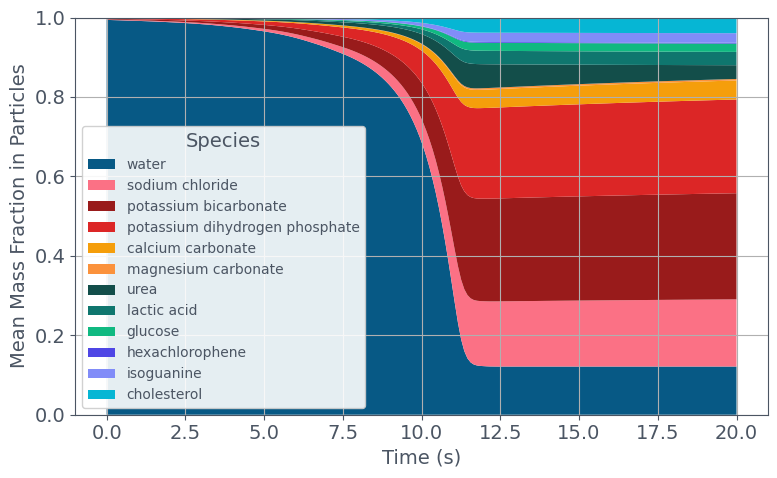

In [11]:

# Compute total mass fraction over time
mass_fraction = species_mass / np.sum(species_mass, axis=1, keepdims=True)

# Set color palette (one color per species)
color_list = [
    TAILWIND["sky"]["800"],  # Water
    TAILWIND["rose"]["400"],  # NaCl
    TAILWIND["red"]["800"],  # KHCO3
    TAILWIND["red"]["600"],  # KH2PO4
    TAILWIND["amber"]["500"],  # Ca(HCO3)2
    TAILWIND["orange"]["400"],  # Mg(HCO3)2
    TAILWIND["teal"]["900"],  # Urea
    TAILWIND["teal"]["700"],  # Lactate
    TAILWIND["green"]["500"],  # Glucose
    TAILWIND["indigo"]["600"],  # Lysozyme
    TAILWIND["indigo"]["400"],  # IgA
    TAILWIND["cyan"]["500"],  # Cholesterol
]

# Create stackplot of species mass fraction
fig, ax = plt.subplots(figsize=(8, 5))
ax.stackplot(
    time_array,
    mass_fraction.T,  # Each row = one species
    labels=short_name,  # Species names
    colors=color_list,
    alpha=1.0,
)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Mean Mass Fraction in Particles")
ax.set_ylim(0, 1)
ax.grid(True)
ax.legend(
    title="Species",
    loc="lower left",
    framealpha=0.9,
    fontsize=10,
)
plt.tight_layout()
plt.show()

## 📈 Step 10: Size Distribution Evolution Over Time

This **contour plot** shows how the **number concentration** of aerosol particles changes **across time and particle size**. It's an excellent way to visualize both **evaporation dynamics** and **distribution narrowing**.

### 🔍 What to Look For:

* The **Y-axis (log scale)** shows particle radius from $10^{-7}$ to $10^{-4}$ meters
* The **X-axis** tracks simulation time from 0 to 120 seconds
* The **color map** shows $\log_{10}$ of number concentration (#/m³)

### 💧 Interpretation:

* **Supermicron particles** (initially >1 µm) evaporate **rapidly** in the first few seconds
* As water is lost, particles shrink and the size distribution **stabilizes**
* Smaller droplets reach their equilibrium sizes **faster** due to greater surface-to-volume ratios

This plot captures the **transient drying behavior** of cough droplets in a controlled environment.


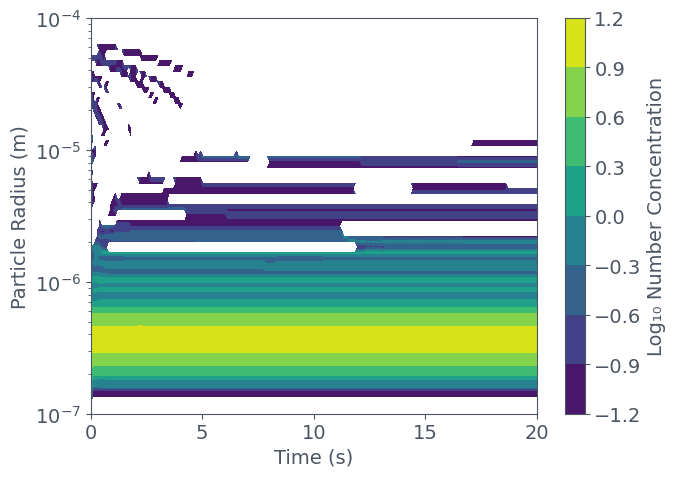

In [12]:

fig, ax = plt.subplots(figsize=(7, 5))

# Create 2D mesh grid for time and particle radius
X, Y = np.meshgrid(time_array, edges[:-1])

# Convert number concentration to log10 scale (avoid log(0) issues)
log_conc = np.log10(
    concentrations,
    where=concentrations > 0,
    out=np.full_like(concentrations, np.nan),  # mask zeros
)

# Contour plot of log concentration
cont = ax.contourf(X, Y, log_conc.T)

# Axis settings
ax.set_yscale("log")
ax.set_ylim(1e-7, 1e-4)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Particle Radius (m)")

# Add colorbar
fig.colorbar(cont, label="Log₁₀ Number Concentration")
plt.tight_layout()
plt.show()

## ✅ Summary: Modeling Cough Droplet Evaporation with Particula

In this notebook, we used **Particula** to simulate the **isothermal evaporation of cough droplets** in a well-mixed air environment. We walked step-by-step through the setup of both **gas-phase and particle-phase systems**, created a realistic **multicomponent chemical composition**, and applied condensation dynamics to understand how droplets evolve over time.

The simulated particles ranged from **submicron to supermicron sizes**, following a lognormal distribution that reflects real-world respiratory emissions. As expected, **supermicron particles took significantly longer for their water mass fraction to decrease**, highlighting the importance of size when modeling indoor exposure or transport of pathogens.

We tracked changes in **size distribution**, **vapor saturation ratio**, and **particle composition** over time, and visualized how water loss drives dynamic shifts in mass fraction and droplet behavior.

---

## 🧠 Take-Home Points

1. **Multicomponent aerosols are easy to build with Particula**
   You can represent realistic droplet mixtures using species-specific mass fractions, thermodynamic properties, and hygroscopicity (κ values).

2. **Water loss dominates early evaporation dynamics**
   In low humidity environments, water rapidly evaporates from smaller particles, while larger ones persist due to slower mass transfer rates.

3. **Gas–particle coupling is size- and concentration-dependent**
   In this example, the **gas-phase RH stayed nearly constant**, showing that low particle loading may have minimal impact on ambient vapor conditions.

4. **Particula supports modular, testable dynamics**
   Processes like condensation, coagulation, and even fixed-RH simulations can be toggled and combined, offering flexibility for exploring a wide range of scenarios.

---

This notebook provides a **foundational example** for respiratory aerosol simulations. You can now extend it to test:

* Different **relative humidity levels**
* Effects of **ventilation or air exchange**
* **Indoor vs. outdoor aerosol transport scenarios**
* Inclusion of **more complex chemistry or temperature effects**
